In [1]:
import torch
from bubbleformer.models import get_model
from bubbleformer.data import BubblemlForecast

In [2]:
test_path = ["/share/crsp/lab/ai4ts/share/BubbleML_f32/PoolBoiling-Saturated-FC72-2D-0.1/Twall-92.hdf5"]
test_dataset = BubblemlForecast(
    filenames=test_path,
    fields=["dfun", "temperature", "velx", "vely"],
    norm="none",
    time_window=5,
    start_time=95
)

In [4]:
model_name = "avit_spatial_only"
model_kwargs = {
    "fields": 4,
    "time_window": 5,
    "patch_size": 16,
    "embed_dim": 384,
    "processor_blocks": 12,
    "num_heads": 6,
    "drop_path": 0.2,
}
model = get_model(model_name, **model_kwargs)

In [5]:
from collections import OrderedDict
weights_path = "/pub/sheikhh1/bubbleformer_logs/avit_spatial_only_poolboiling_saturated_36173273/hpc_ckpt_3.ckpt"
model_data = torch.load(weights_path, weights_only=False)
print(model_data.keys())
diff_term, div_term = model_data['hyper_parameters']['normalization_constants']
diff_term = torch.tensor(diff_term)
div_term = torch.tensor(div_term)
weight_state_dict = OrderedDict()
for key, val in model_data["state_dict"].items():
    name = key[6:]
    weight_state_dict[name] = val
del model_data

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])


In [6]:
model.load_state_dict(weight_state_dict)

<All keys matched successfully>

In [7]:
from bubbleformer.utils.losses import LpLoss
_, _ = test_dataset.normalize(diff_term, div_term)
criterion = LpLoss(d=2, p=2, reduce_dims=[0,1], reductions=["mean", "mean"])
model.eval()
start_time = test_dataset.start_time
skip_itrs = test_dataset.time_window
model_preds = []
model_targets = []
timesteps = []
for itr in range(0, 500, skip_itrs):
    inp, tgt = test_dataset[itr]
    print(f"Autoreg pred {itr}, inp tw [{start_time+itr}, {start_time+itr+skip_itrs}], tgt tw [{start_time+itr+skip_itrs}, {start_time+itr+2*skip_itrs}]")
    if len(model_preds) > 0:
        inp = model_preds[-1] # T, C, H, W
    inp = inp.float().unsqueeze(0)
    pred = model(inp)
    pred = pred.squeeze(0).detach().cpu()
    tgt = tgt.detach().cpu()

    model_preds.append(pred)
    model_targets.append(tgt)
    timesteps.append(torch.arange(start_time+itr+skip_itrs, start_time+itr+2*skip_itrs))
    print(criterion(pred, tgt))

Autoreg pred 0, inp tw [95, 100], tgt tw [100, 105]
tensor(0.0655)
Autoreg pred 5, inp tw [100, 105], tgt tw [105, 110]
tensor(0.1298)
Autoreg pred 10, inp tw [105, 110], tgt tw [110, 115]
tensor(0.1635)
Autoreg pred 15, inp tw [110, 115], tgt tw [115, 120]
tensor(0.2124)
Autoreg pred 20, inp tw [115, 120], tgt tw [120, 125]
tensor(0.2732)
Autoreg pred 25, inp tw [120, 125], tgt tw [125, 130]
tensor(0.3269)
Autoreg pred 30, inp tw [125, 130], tgt tw [130, 135]
tensor(0.3568)
Autoreg pred 35, inp tw [130, 135], tgt tw [135, 140]
tensor(0.3924)
Autoreg pred 40, inp tw [135, 140], tgt tw [140, 145]
tensor(0.4155)
Autoreg pred 45, inp tw [140, 145], tgt tw [145, 150]
tensor(0.4361)
Autoreg pred 50, inp tw [145, 150], tgt tw [150, 155]
tensor(0.4537)
Autoreg pred 55, inp tw [150, 155], tgt tw [155, 160]
tensor(0.4886)
Autoreg pred 60, inp tw [155, 160], tgt tw [160, 165]
tensor(0.5356)
Autoreg pred 65, inp tw [160, 165], tgt tw [165, 170]
tensor(0.5711)
Autoreg pred 70, inp tw [165, 170], t

In [8]:
from bubbleformer.utils.plot_utils import plot_bubbleml

model_preds = torch.cat(model_preds, dim=0)         # T, C, H, W
model_targets = torch.cat(model_targets, dim=0)     # T, C, H, W
timesteps = torch.cat(timesteps, dim=0)             # T,
num_var = len(test_dataset.fields)                  # C

preds = model_preds * div_term.view(1, num_var, 1, 1) + diff_term.view(1, num_var, 1, 1)     # denormalize
targets = model_targets * div_term.view(1, num_var, 1, 1) + diff_term.view(1, num_var, 1, 1) # denormalize



0 files done
25 files done
50 files done
75 files done
100 files done
125 files done
150 files done
175 files done
200 files done
225 files done
250 files done
275 files done
300 files done
325 files done
350 files done
375 files done
400 files done
425 files done
450 files done
475 files done


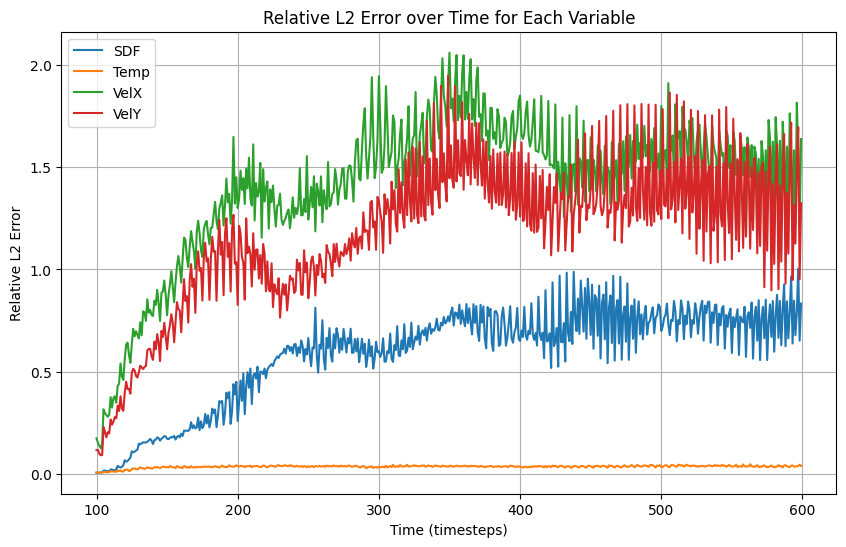

In [9]:
import os
save_dir = "/pub/sheikhh1/bubbleformer_logs/avit_spatial_only_poolboiling_saturated_36173273/epoch_200_outputs/sat_92"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "predictions.pt")

torch.save({"preds": preds, "targets": targets, "timesteps": timesteps}, save_path)
plot_bubbleml(preds, targets, timesteps, save_dir)

In [10]:
def get_eikonal_loss(phi):
    """
    phi = predicted sdf torch.Tensor(T,H,W)
    """
    dx = 1/32
    grad_x = (phi[:, :, 2:] - phi[:, :, :-2]) / (2 * dx)
    grad_y = (phi[:, 2:, :] - phi[:, :-2, :]) / (2 * dx)

    grad_x = torch.nn.functional.pad(grad_x, (1, 1), mode="replicate")
    grad_y = torch.nn.functional.pad(grad_y, (0, 0, 1, 1), mode="replicate")

    grad_magnitude = torch.sqrt(grad_x**2 + grad_y**2)
    loss_map = torch.abs(grad_magnitude - 1)
    mean_loss = torch.mean(loss_map, dim=(1, 2))
    return mean_loss

In [11]:
model_eikonal_loss = get_eikonal_loss(model_preds[:,0,:,:]).numpy()
sim_eikonal_loss = get_eikonal_loss(model_targets[:,0,:,:]).numpy()
timesteps = timesteps.numpy()
                                    

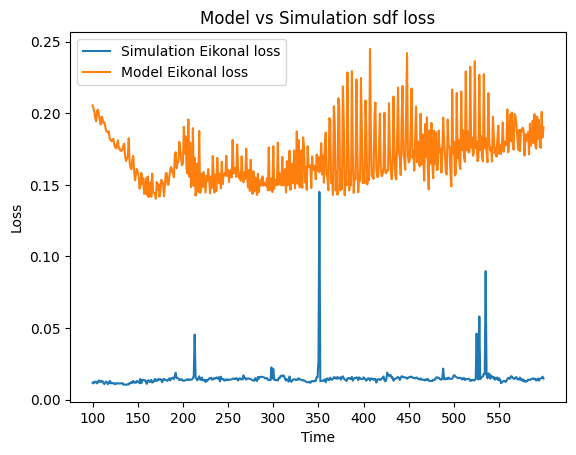

In [19]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(timesteps, sim_eikonal_loss, label='Simulation Eikonal loss')
plt.plot(timesteps, model_eikonal_loss, label='Model Eikonal loss')
plt.xticks(np.arange(100, 600, 50))
plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Model vs Simulation sdf loss')
plt.legend()